# Introduction

Dataset used in this notebook aims to classificate stars, galaxies, and quasars based on their spectral characteristics. Support Vector Machine (SVM) and Random Forest algorithms are used for classification purposes in this notebook. The dataset is an imbalanced dataset. For this reason, Synthetic Minority Oversampling Technique (SMOTE) is used to eliminate the imbalance between classes. Outlier values are detected with the Local Outlier Factor and these values are removed from the dataset. In the 16-dimensional data set, the correlations of the features with the class label are checked and the features with a correlation greater than 0.16 are used for classification. In addition, the seaborn library and the yellow brick library are used for data visualization.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
# sns.set(rc = {'figure.figsize':(12,7)})

import os

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report


from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from collections import Counter

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.metrics import balanced_accuracy_score

# Load and Check Data

In [2]:
df = pd.read_csv("star_classification.csv")

In [3]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [5]:
df["class"].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

In [6]:
a, b, c = df["class"].value_counts() / len(df)
print(f"Total percentage of Galaxies : {round(a*100, 1)}%")
print(f"Total percentage of Stars : {round(b*100, 1)}%")
print(f"Total percentage of QSO : {round(c*100, 1)}%")

Total percentage of Galaxies : 59.4%
Total percentage of Stars : 21.6%
Total percentage of QSO : 19.0%


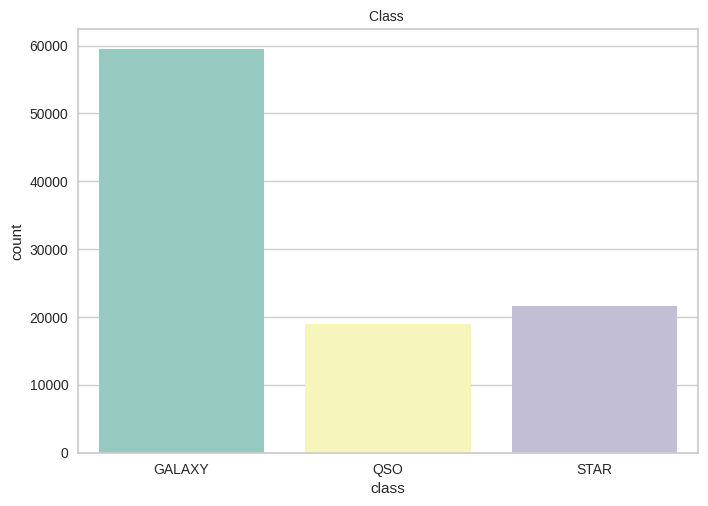

In [8]:
sns.countplot(x=df["class"], palette="Set3")
plt.title("Class ",fontsize=10)
plt.show()

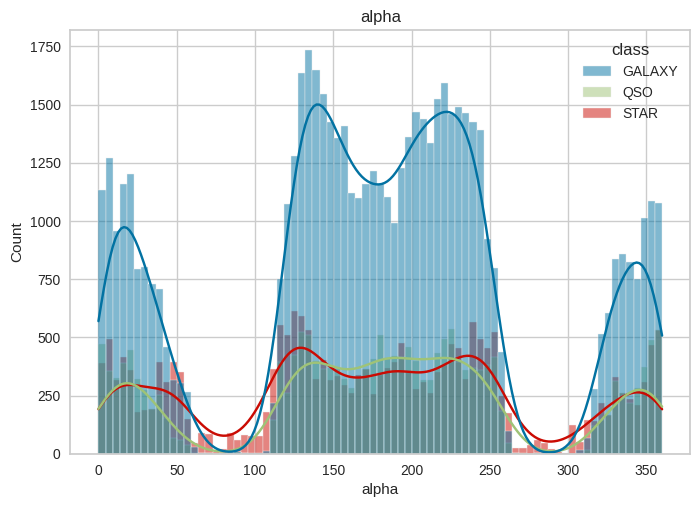

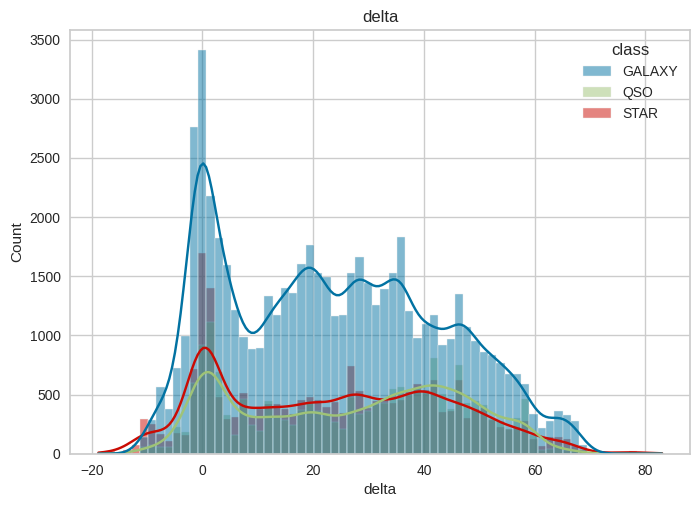

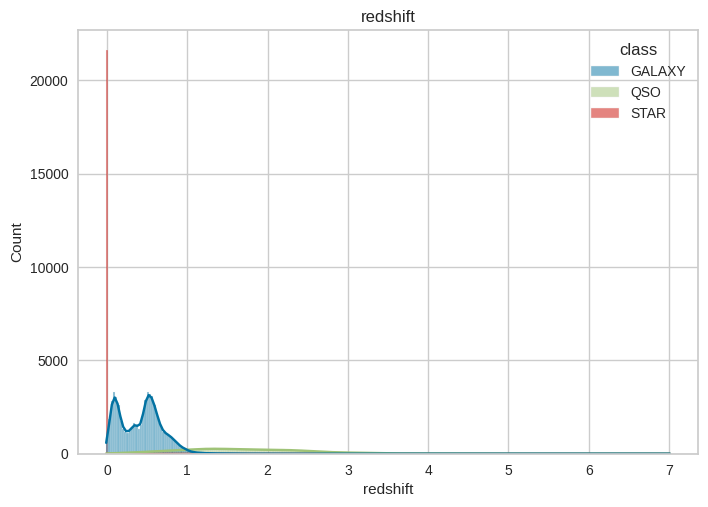

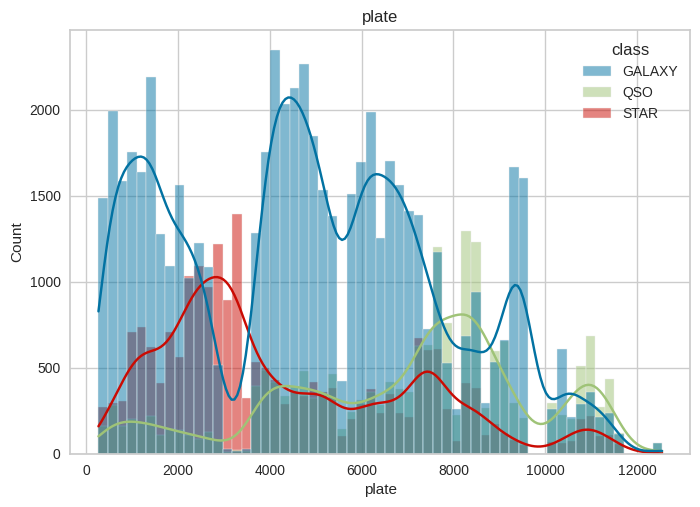

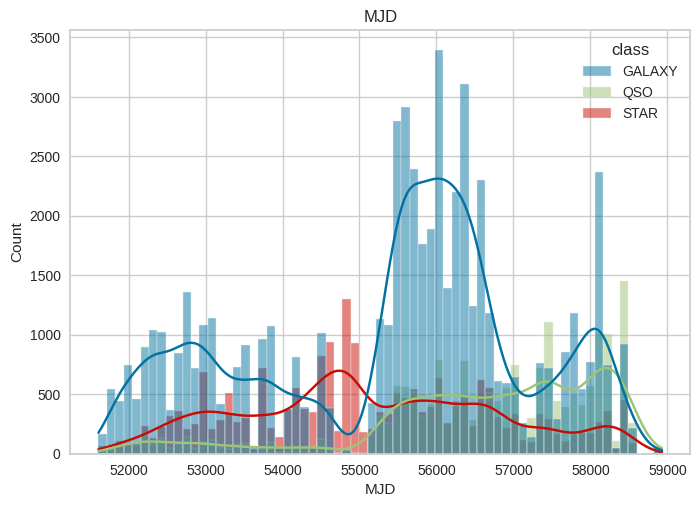

In [9]:
# We can train out models faster if we choose those features which can distinguish
# well between out classes

# As alpha, delta, u, g, r, i, z, redshift, plate, MJD
# are astronomical quantities, therefore,
# we'll keep them as our primary feature...

for i in ['alpha', 'delta','redshift', 'plate', 'MJD']:
    plt.figure() #figsize=(13,7))
    sns.histplot(data=df, x=i, kde=True, hue="class")
    plt.title(i)
    plt.show()

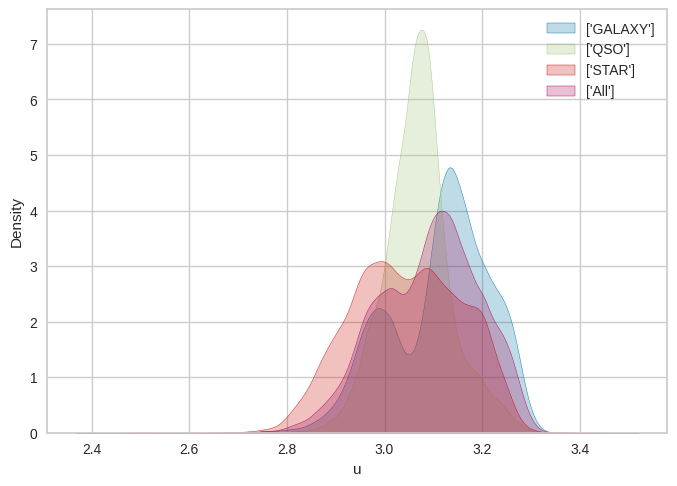

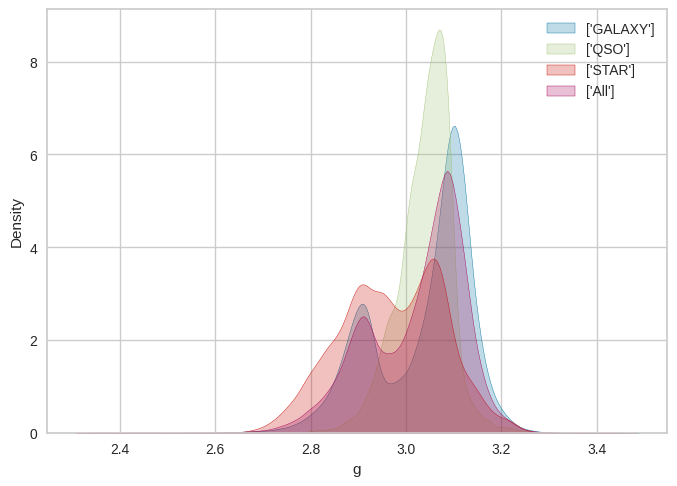

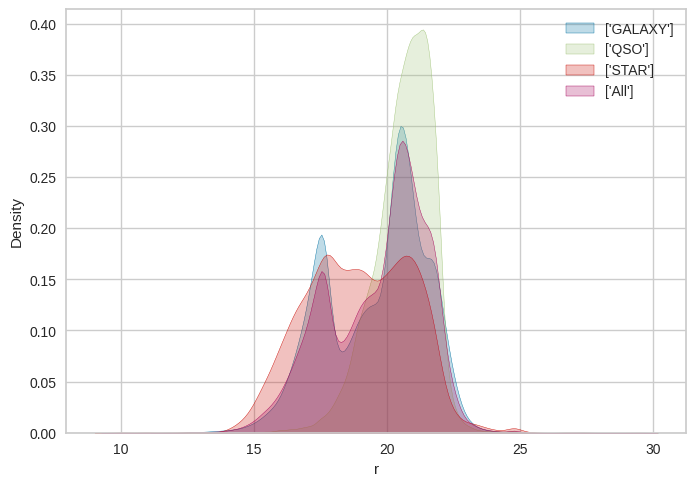

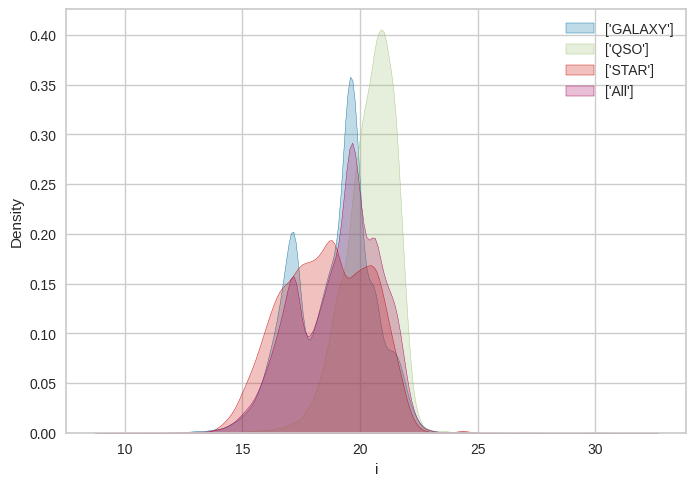

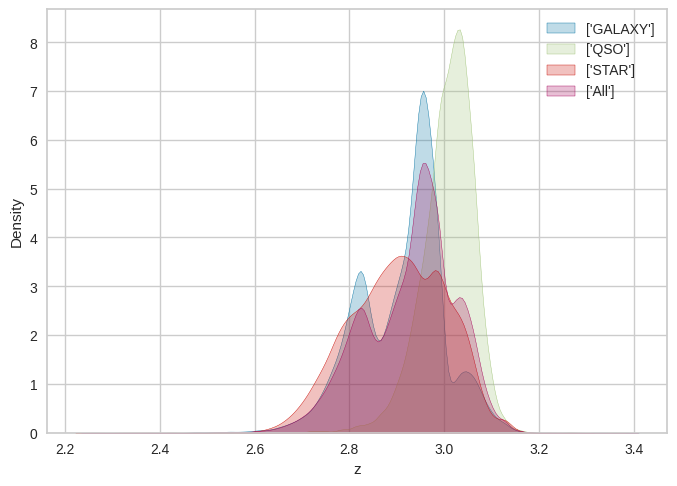

In [10]:
le = LabelEncoder()

data = df.copy()

data["class"] = le.fit_transform(data["class"])
data["class"] = data["class"].astype(int)

def plot(column):
    for i in range(3):
        sns.kdeplot(data=data[data["class"] == i][column],
                    label = le.inverse_transform([i]), fill = True)
    sns.kdeplot(data=data[column],label = ["All"], fill = True)
    plt.legend()

def log_plot(column):
    for i in range(3):
        sns.kdeplot(data=np.log(data[data["class"] == i][column]),
                    label = le.inverse_transform([i]), fill = True)
    sns.kdeplot(data=np.log(data[column]),label = ["All"], fill = True)
    plt.legend()

# plot('u')
# plt.show()
log_plot('u')
plt.show()

# plot('g')
# plt.show()
log_plot('g')
plt.show()

plot('r')
plt.show()

plot('i')
plt.show()

# plot('z')
# plt.show()
#apply log due to extreme values
log_plot('z')
plt.show()

# Detect Outliers

In [11]:
# df = pd.read_csv("star_classification.csv")

# df["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df["class"]]
df['class'].replace(['GALAXY', 'QSO', 'STAR'], [0,1,2], inplace=True)

In [12]:
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(df)

In [13]:
x_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score

#threshold
threshold2 = -1.5
filtre2 = outlier_score["score"] < threshold2
outlier_index = outlier_score[filtre2].index.tolist()

In [14]:
print(f'Number of outliers: {len(outlier_index)}')

Number of outliers: 15256


In [15]:
df.drop(outlier_index, inplace=True)

# Feature Selection

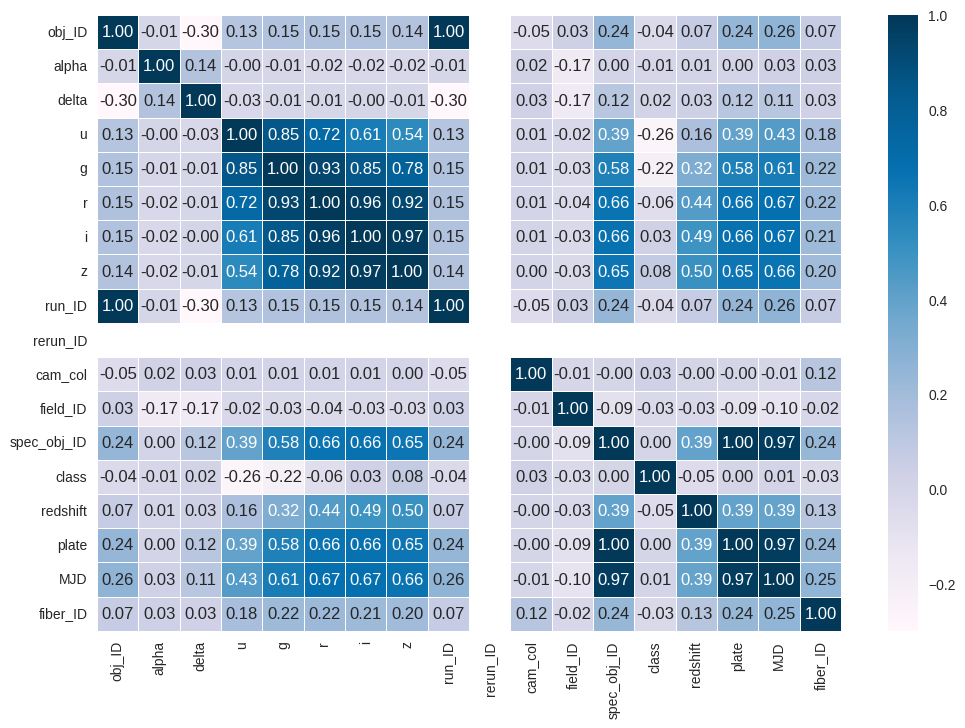

In [16]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

In [17]:
corr = df.corr()

In [18]:
corr["class"].sort_values()

u             -0.263310
g             -0.216012
r             -0.061318
redshift      -0.045683
run_ID        -0.035732
obj_ID        -0.035729
field_ID      -0.032323
fiber_ID      -0.031727
alpha         -0.013221
spec_obj_ID    0.000059
plate          0.000060
MJD            0.007185
delta          0.015855
cam_col        0.030236
i              0.030689
z              0.081337
class          1.000000
rerun_ID            NaN
Name: class, dtype: float64

### Drop unneeded features

In [19]:
df = df.drop(['obj_ID','alpha','delta',
              'run_ID','rerun_ID','cam_col',
              'field_ID','fiber_ID'], axis = 1)

In [20]:
df.head()

,u,g,r,i,z,spec_obj_ID,class,redshift,plate,MJD
0,23.87882,22.27530,20.39501,19.16573,18.79371,6.543777e+18,0,0.634794,5812,56354
1,24.77759,22.83188,22.58444,21.16812,21.61427,1.176014e+19,0,0.779136,10445,58158
3,22.13682,23.77656,21.61162,20.50454,19.25010,1.030107e+19,0,0.932346,9149,58039
4,19.43718,17.58028,16.49747,15.97711,15.54461,6.891865e+18,0,0.116123,6121,56187
6,21.46973,21.17624,20.92829,20.60826,20.42573,1.246262e+19,1,0.586455,11069,58456


<a id='4'></a><br>
# Dealing with Imbalanced Data

In [21]:
x = df.drop(['class'], axis = 1)
y = df.loc[:,'class'].values

### Synthetic Minority Oversampling Technique (SMOTE)
balances class distribution by increasing minority class examples by replicating them

In [22]:
sm = SMOTE(random_state=42)
print('Original dataset shape %s' % Counter(y))
x, y = sm.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 50695, 2: 17890, 1: 16159})
Resampled dataset shape Counter({0: 50695, 1: 50695, 2: 50695})


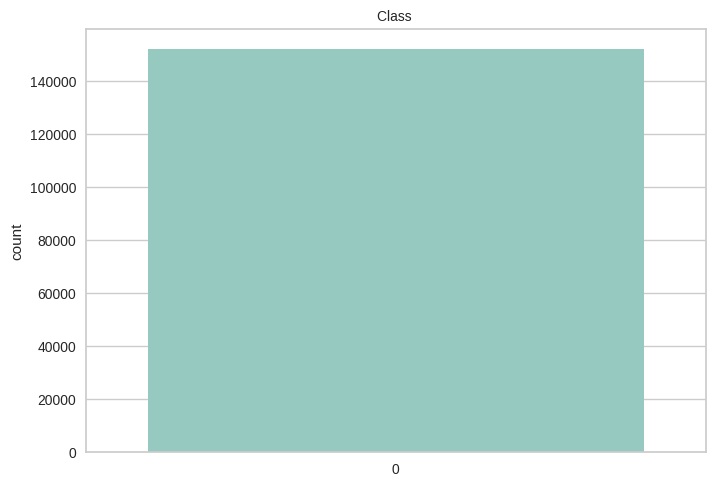

In [23]:
sns.countplot(y, palette='Set3')
plt.title("Class ",fontsize=10)
plt.show()

# Data Scaling
Standardize features by removing the mean and scaling to unit variance.

In [24]:
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

<a id='7'></a><br>
# Train / Test Split

In [25]:
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size = 0.33,
                     random_state = 42)

<a id='8'></a><br>
# Classifiers

* SVC
  * ``A SVM constructs a hyperplane or set of hyperplanes in a high or infinite-dimensional space, which can be used for classification, regression, or other tasks like outliers detection.``
* Random Forest Classifier
  * ``A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.``
* Decision Tree Classifier
  * ``The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.``

In [26]:
classes = ['GALAXY','STAR','QSO']

def fit(model):
    model.fit(x_train, y_train)
    predicted = model.predict(x_test)
    score = model.score(x_test, y_test)
    score_ = np.mean(score)

    print('Accuracy : %.3f' % (score_))

    cm = ConfusionMatrix(model, classes=classes, cmap='GnBu')

    cm.fit(x_train, y_train)
    cm.score(x_test, y_test)
    cm.show()

    print(classification_report(y_test, predicted))

    visualizer = ROCAUC(model, classes=classes)
    set_palette('bold')
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()

    visualizer = ClassPredictionError(model, classes=classes)
    set_palette('pastel')
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()


SVC
Accuracy : 0.971


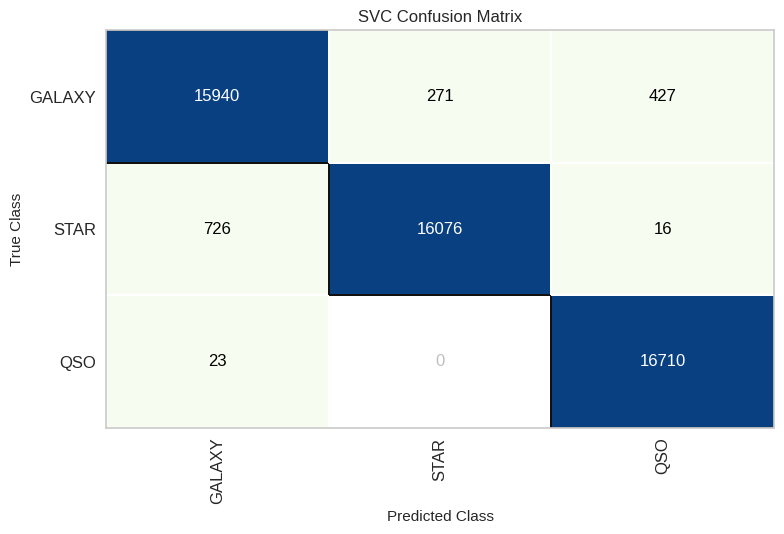

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     16638
           1       0.98      0.96      0.97     16818
           2       0.97      1.00      0.99     16733

    accuracy                           0.97     50189
   macro avg       0.97      0.97      0.97     50189
weighted avg       0.97      0.97      0.97     50189



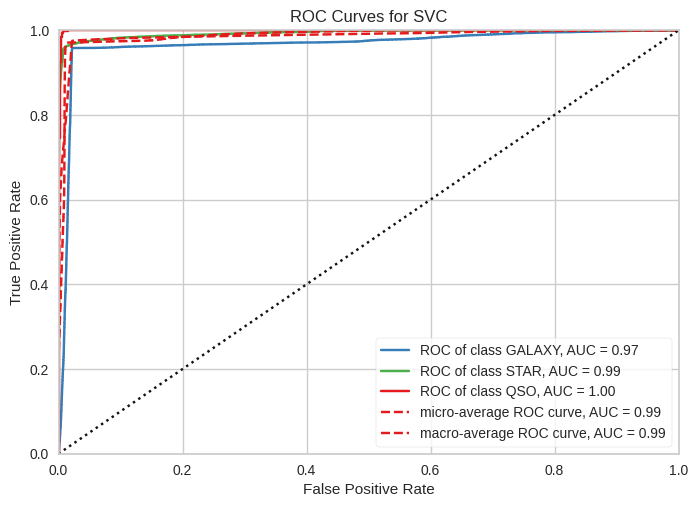

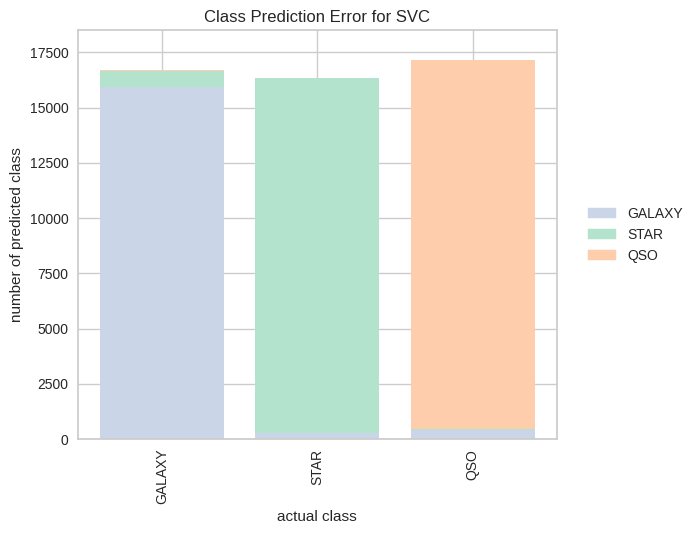

Decision Tree Classifier
Accuracy : 0.972


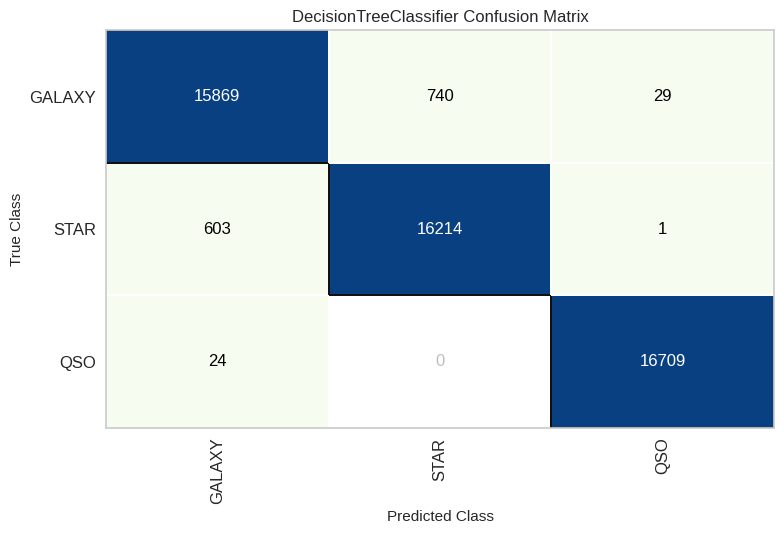

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     16638
           1       0.96      0.96      0.96     16818
           2       1.00      1.00      1.00     16733

    accuracy                           0.97     50189
   macro avg       0.97      0.97      0.97     50189
weighted avg       0.97      0.97      0.97     50189



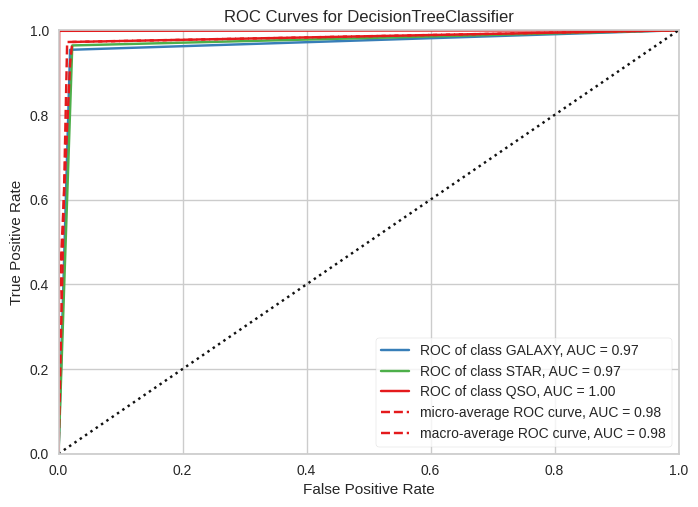

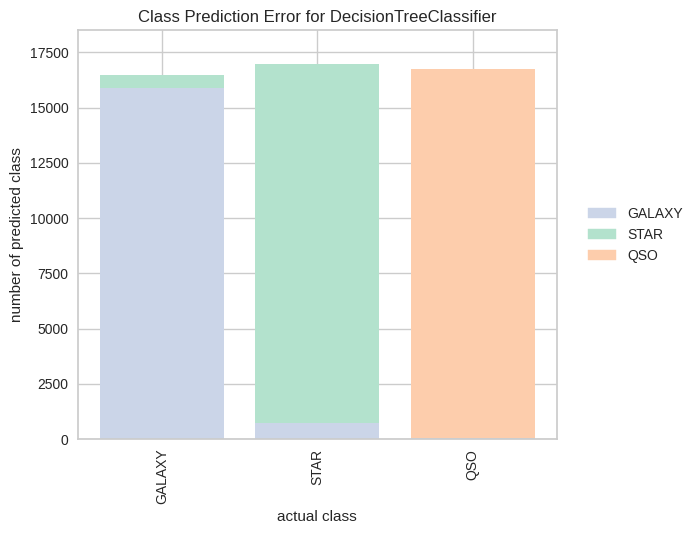

Random Forest Classifier
Accuracy : 0.983


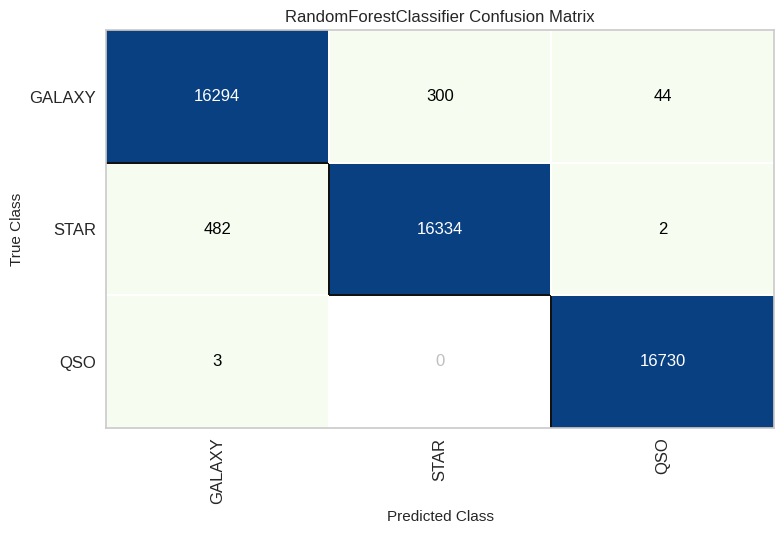

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     16638
           1       0.98      0.97      0.98     16818
           2       1.00      1.00      1.00     16733

    accuracy                           0.98     50189
   macro avg       0.98      0.98      0.98     50189
weighted avg       0.98      0.98      0.98     50189



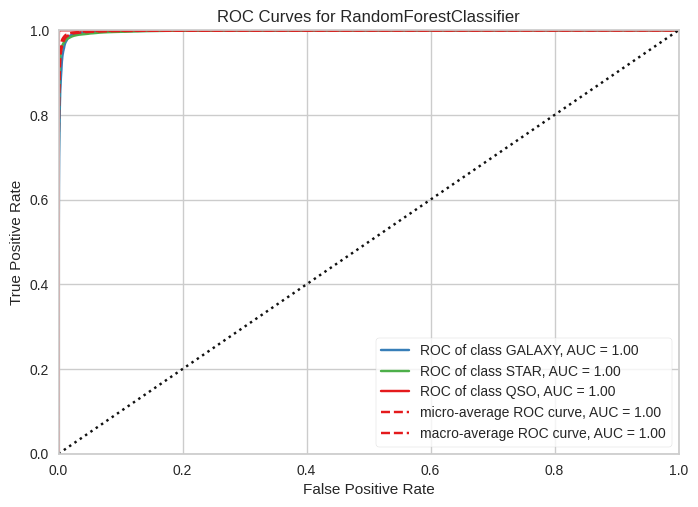

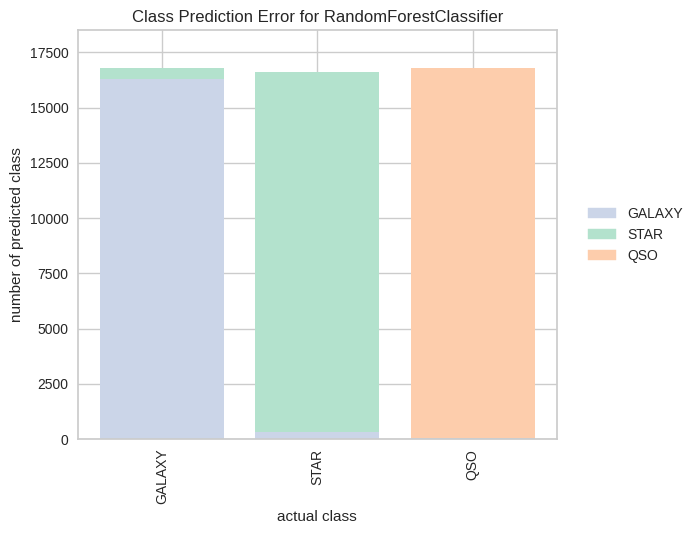

Logistic Regression
Accuracy : 0.968


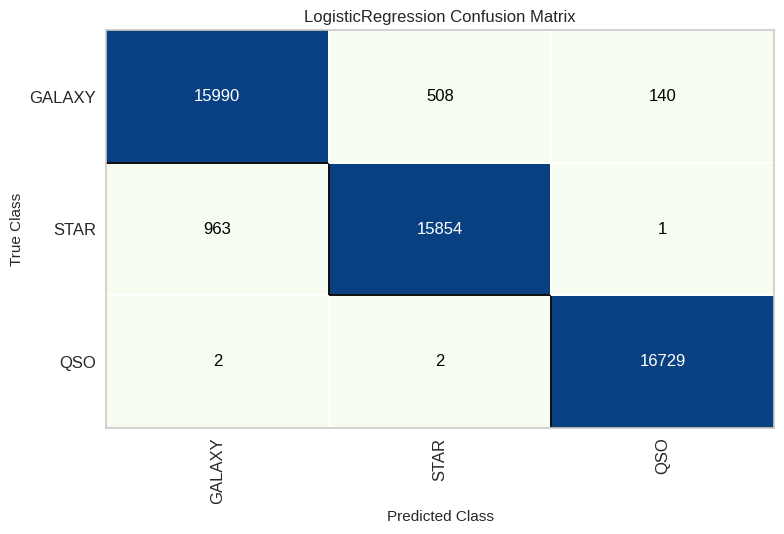

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     16638
           1       0.97      0.94      0.96     16818
           2       0.99      1.00      1.00     16733

    accuracy                           0.97     50189
   macro avg       0.97      0.97      0.97     50189
weighted avg       0.97      0.97      0.97     50189



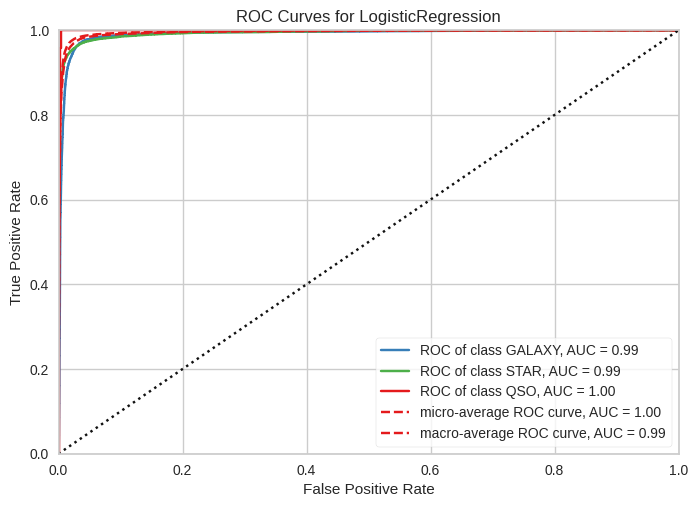

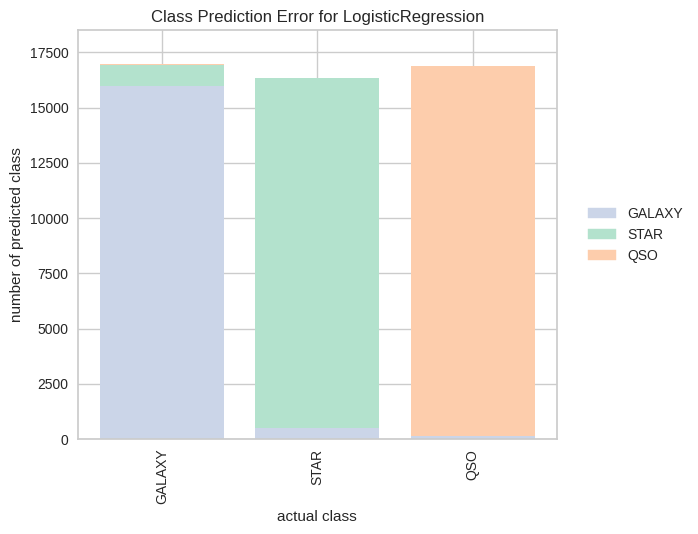

In [27]:
for m in [('SVC', svm.SVC(kernel='rbf', C=1, random_state=42)),
          ('Decision Tree Classifier', DecisionTreeClassifier()),
          ('Random Forest Classifier', RandomForestClassifier(n_jobs=-1)),
          ('Logistic Regression', LogisticRegression(C=1e5))]:
    print(m[0])
    fit(m[1])

## CatBoost Classifier
``Gradient boosting on decistion trees``

https://www.kaggle.com/code/prashant111/catboost-classifier-in-python/notebook

In [28]:
%%time
# CatBoostClassifier with cross validation
from sklearn.model_selection import StratifiedKFold as skf
skfold = skf(n_splits = 4, shuffle = True, random_state = 70)

model = CatBoostClassifier(verbose  = 0)
score = cross_val_score(model, x_train, y_train, cv = skfold)
print('CatBoostClassifier : ' + " {:.2f}%".format(np.mean(score) * 100))

CatBoostClassifier :  98.06%
CPU times: user 4min 38s, sys: 8.09 s, total: 4min 46s
Wall time: 29.4 s


# LGBM Classifier
Light Gradient Boosting Machine - gradient boosting framework that uses tree based learning algorithms

``LightGBM grows tree vertically while other tree based learning algorithms grow trees horizontally. 
It means that LightGBM grows tree leaf-wise while other algorithms grow level-wise. It will choose 
the leaf with max delta loss to grow. When growing the same leaf, leaf-wise algorithm can reduce more 
loss than a level-wise algorithm.
``

https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python

In [29]:
%%time
#LGBC model with cross validation
model = LGBMClassifier()
score = cross_val_score(model , x_train , y_train ,cv=skfold)
print('Light GradientBoostingClassifier : ' + " {:.2f}%".format(np.mean(score) * 100))

Light GradientBoostingClassifier :  98.00%
CPU times: user 25.7 s, sys: 80.4 ms, total: 25.7 s
Wall time: 2.2 s
